In [1]:
!pip install causalml
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 535 kB 4.1 MB/s 
     |████████████████████████████████| 76 kB 2.3 MB/s 
     |████████████████████████████████| 569 kB 43.8 MB/s 
     |████████████████████████████████| 1.8 MB 47.2 MB/s 
     |████████████████████████████████| 722 kB 47.4 MB/s 
     |████████████████████████████████| 115 kB 55.8 MB/s 
     |████████████████████████████████| 52 kB 1.2 MB/s 
  Created wheel for causalml: filename=causalml-0.13.0-cp37-cp37m-linux_x86_64.whl size=1293717 sha256=5d0d03f3509f8bfd6b757ba0c745e5c23bb57fefd2bf71fe4bd1259544d782a4
  Stored in directory: /root/.cache/pip/wheels/a6/5b/69/42cc8e90cd501e2e912b073ec0747ee8daea28baaf4be0c7b9
Successfully built causalml
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, classification_report

import scikitplot as skplt

from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier

from causalml.inference.meta import BaseSClassifier
from causalml.dataset import make_uplift_classification
from causalml.inference.tree import UpliftRandomForestClassifier
import causalml.metrics as metrics
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

from IPython.display import Image

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["font.size"] = 25
sns.set()

In [13]:
data = pd.read_csv("https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/employee_turnover/turnover.csv", engine='python',encoding='latin1')

**Introduction**
HR khawatir dengan banyaknya karyawan yang mengundurkan diri. Mereka berasumsi bahwa karyawan yang mendapatkan pelatihan pada saat probation akan cenderung lebih loyal dengan perusahaan jika dibandingkan dengan yang tidak mendapat pelatihan. Anda sebagai HR analyst ditunjuk untuk menguji asumsi ini.

In [14]:
data.head()

,stag,event,gender,age,industry,profession,traffic,coach,head_gender,greywage,way,extraversion,independ,selfcontrol,anxiety,novator
0,7.030801,1,m,35.0,Banks,HR,rabrecNErab,no,f,white,bus,6.2,4.1,5.7,7.1,8.3
1,22.965092,1,m,33.0,Banks,HR,empjs,no,m,white,bus,6.2,4.1,5.7,7.1,8.3
2,15.934292,1,f,35.0,PowerGeneration,HR,rabrecNErab,no,m,white,bus,6.2,6.2,2.6,4.8,8.3
3,15.934292,1,f,35.0,PowerGeneration,HR,rabrecNErab,no,m,white,bus,5.4,7.6,4.9,2.5,6.7
4,8.410678,1,m,32.0,Retail,Commercial,youjs,yes,f,white,bus,3.0,4.1,8.0,7.1,3.7


In [15]:
# cek data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1129 entries, 0 to 1128
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   stag          1129 non-null   float64
 1   event         1129 non-null   int64  
 2   gender        1129 non-null   object 
 3   age           1129 non-null   float64
 4   industry      1129 non-null   object 
 5   profession    1129 non-null   object 
 6   traffic       1129 non-null   object 
 7   coach         1129 non-null   object 
 8   head_gender   1129 non-null   object 
 9   greywage      1129 non-null   object 
 10  way           1129 non-null   object 
 11  extraversion  1129 non-null   float64
 12  independ      1129 non-null   float64
 13  selfcontrol   1129 non-null   float64
 14  anxiety       1129 non-null   float64
 15  novator       1129 non-null   float64
dtypes: float64(7), int64(1), object(8)
memory usage: 141.2+ KB


In [16]:
data.corr()

,stag,event,age,extraversion,independ,selfcontrol,anxiety,novator
stag,1.000000,-0.048361,-0.197381,-0.088227,0.000550,0.077076,0.014755,-0.037633
event,-0.048361,1.000000,-0.048751,0.015458,0.051864,-0.040040,-0.063232,0.006825
age,-0.197381,-0.048751,1.000000,-0.149753,0.056129,0.038996,0.057782,0.039509
extraversion,-0.088227,0.015458,-0.149753,1.000000,-0.200052,-0.538039,-0.135046,0.297375
independ,0.000550,0.051864,0.056129,-0.200052,1.000000,-0.165795,-0.427209,0.023865
selfcontrol,0.077076,-0.040040,0.038996,-0.538039,-0.165795,1.000000,-0.107568,-0.565972
anxiety,0.014755,-0.063232,0.057782,-0.135046,-0.427209,-0.107568,1.000000,0.246668
novator,-0.037633,0.006825,0.039509,0.297375,0.023865,-0.565972,0.246668,1.000000


**Soal 1 **

Lakukanlah eksplorasi pada data antara variabel prediktor dan variabel target (event). Buatlah kesimpulan dari tiap analisis yang dibuat (i.e: tidak hanya menampilkan visualisasi namun memberikan insight dari visualisasi)


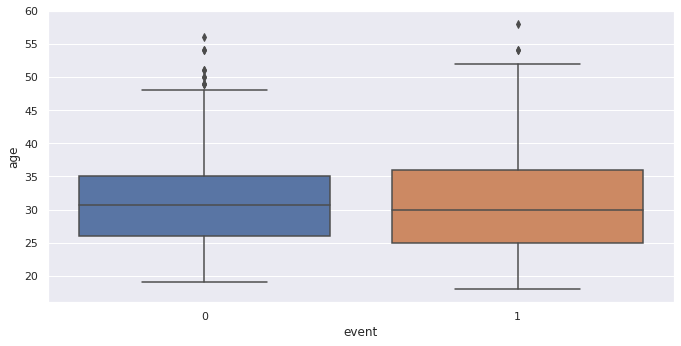

In [22]:
# cek age dengan event
sns.boxplot(data=data, y= "age", x="event")

antara karyawan yang churn dan tidak memiliki nilai tengah usia yang hampir mirip yaitu di rentang 30an.. artinya secara usia kedua kategori ini punya distribusi usia yang hampir sama

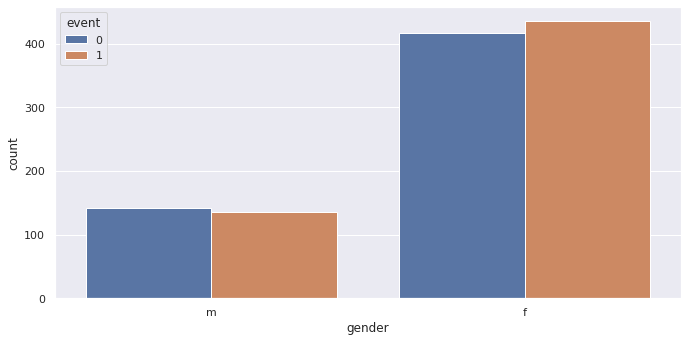

In [30]:
# cek gender dengan event
sns.countplot(data=data, x= "gender", hue="event")

Secara total karyawan female 3 kali lebih banyak dibanding karyawan male. 

Berbeda dengan male, jumlah churn pada female lebih banyak daripada yang notchurn.

In [40]:
# cek hasil big5test scales antara yang churn dan yang tidak
datachurn = data[data["event"] == 1]
datachurn[["event","extraversion","independ","selfcontrol","anxiety","novator"]].mean()

event           1.000000
extraversion    5.620665
independ        5.565324
selfcontrol     5.518914
anxiety         5.558844
novator         5.892469
dtype: float64

In [55]:
datachurn.groupby(["profession"])["event"].count().sort_values(ascending= False)

profession
HR                     357
Sales                   35
IT                      25
Marketing               21
etc                     20
BusinessDevelopment     16
Consult                 16
Commercial              15
manage                  15
Finanñe                 12
Teaching                12
Engineer                11
Accounting               6
Law                      5
PR                       5
Name: event, dtype: int64

In [41]:
dataNoChurn = data[data["event"] == 0]
dataNoChurn[["event","extraversion","independ","selfcontrol","anxiety","novator"]].mean()

event           0.000000
extraversion    5.563441
independ        5.388710
selfcontrol     5.677419
anxiety         5.774910
novator         5.866487
dtype: float64

In [54]:
dataNoChurn.groupby(["profession"])["event"].count().sort_values(ascending= False)

profession
HR                     400
IT                      49
Sales                   31
etc                     17
BusinessDevelopment     11
Marketing               10
Consult                  9
Commercial               8
manage                   7
Finanñe                  5
Accounting               4
Engineer                 4
Law                      2
PR                       1
Name: event, dtype: int64

1. rata- rata nilai **anxiety dan selfcontrol untuk karyawan yang churn lebih kecil**dibandingkan dengan karyawan No Churn.

2. dan top 3 profesi terbanyak untuk kedua kategori churn dan NoChurn adalah sama, yaitu profesi **HR, IT dan sales**


**Soal 2**

Buatlah model uplift menggunakan uplift-tree atau uplift-forest dan hitung ada berapa banyak karyawan yang masuk dalam kategori persuadable


**initialize variable**

In [70]:

# treatment variable
treatment_variable = "coach"
# target variable
target_variable = "event"
# control category
control_category = "no"
# treatment category
treatment_category = "yes"
# category to exclude if needed
exclusion_category = "my head"
# column to drop
variable_to_drop = ['head_gender','greywage','way','extraversion','independ','novator',"gender","age","industry","profession","traffic","head_gender","greywage"]
# column to encode
categorical_columns = ["stag"]

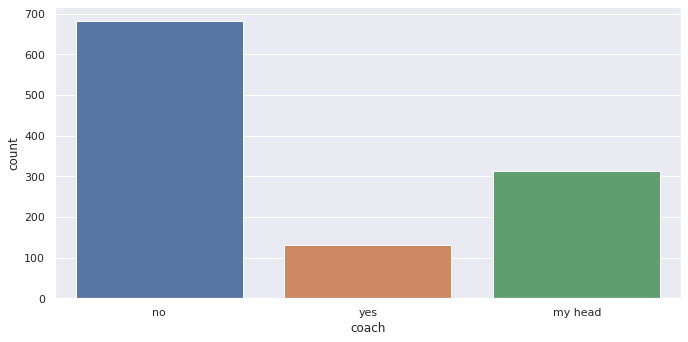

In [59]:
# cek treatment distribution
sns.countplot(data = data, x = treatment_variable);

In [71]:
#Remove category if any segment need to be excluded
if exclusion_category != None:
 data = data.loc[data[treatment_variable] != exclusion_category].reset_index(drop=True)

In [72]:
n_treatment = data[treatment_variable].nunique()

In [73]:
n_treatment

2

In [74]:
data.coach.value_counts()

no     683
yes    132
Name: coach, dtype: int64

Train Test Split Data

In [75]:
X_train, X_test = train_test_split(
    data.drop(variable_to_drop, axis = 1), 
    test_size = 0.5, 
    random_state = 1000
)

Data Processing

In [76]:
X_train.head()

,stag,event,coach,selfcontrol,anxiety
731,4.763860,0,no,4.1,8.7
340,64.295688,1,no,10.0,9.4
633,99.778234,0,yes,7.2,7.1
85,11.498973,1,no,5.7,4.0
607,81.248460,0,no,7.2,4.8


In [77]:
X_test.head()

,stag,event,coach,selfcontrol,anxiety
677,36.731006,0,yes,7.2,5.6
26,16.919918,1,no,4.1,8.7
588,2.036961,1,no,5.7,8.7
33,22.735113,1,no,4.9,3.3
349,17.609856,1,no,3.3,6.3


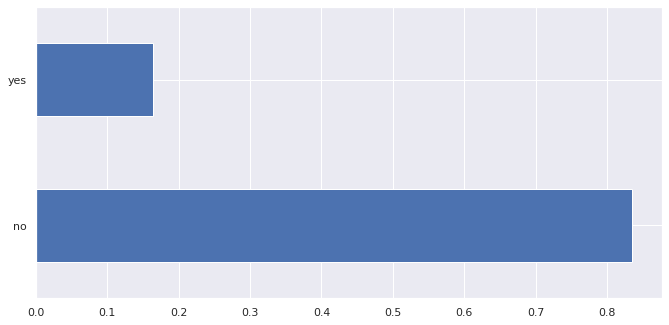

In [79]:
X_train.coach.value_counts(normalize = True).plot.barh();

In [80]:
# Encode categorical variables on X train data
dummies = pd.get_dummies(X_train[categorical_columns], drop_first=True)
X_train = pd.concat([X_train.drop(categorical_columns, axis=1), dummies], axis=1)

# Encode categorical variables on X test data
dummies = pd.get_dummies(X_test[categorical_columns], drop_first=True)
X_test = pd.concat([X_test.drop(categorical_columns, axis=1), dummies], axis=1)

In [82]:
is_treat = X_train[X_train.coach != control_category]
not_treat = X_train[X_train.coach == control_category]

In [83]:
is_treat.head()

,event,coach,selfcontrol,anxiety,stag
633,0,yes,7.2,7.1,99.778234
724,0,yes,7.2,7.1,48.689938
550,1,yes,2.6,7.1,23.819302
424,1,yes,4.1,2.5,17.839836
528,1,yes,10.0,4.8,79.014374


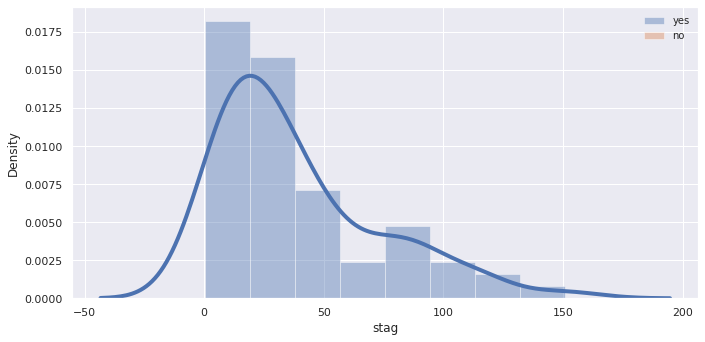

In [87]:
# bins = 10
sns.distplot(is_treat.query("coach == 'yes'").stag, hist=True, kde=True, kde_kws={'linewidth': 4}, label='yes')
sns.distplot(is_treat.query("coach == 'no'").stag, hist=True, kde=True, kde_kws={'linewidth': 4}, label='no')
# sns.distplot(not_treat.history, hist=True, kde=True, kde_kws={'linewidth': 4}, label='control')
plt.legend(frameon=False, loc=0, ncol=1, prop={'size': 10});

Uplift-Tree (Uplift Random Forest) Modelling

In [89]:
X_train.head()

,event,coach,selfcontrol,anxiety,stag
731,0,no,4.1,8.7,4.763860
340,1,no,10.0,9.4,64.295688
633,0,yes,7.2,7.1,99.778234
85,1,no,5.7,4.0,11.498973
607,0,no,7.2,4.8,81.248460


In [90]:
x_col = X_train.drop([treatment_variable, target_variable], axis = 1).columns.tolist()
print(x_col)

['selfcontrol', 'anxiety', 'stag']


In [88]:
# Define uplift random forest classifier

uplift_model = UpliftRandomForestClassifier(control_name=control_category, random_state=1000)

In [91]:
# Fit Model to data

uplift_model.fit(
    X_train[x_col].values,
    treatment = X_train[treatment_variable].values,
    y = X_train[target_variable].values
)

In [92]:
# Prediksi dengan training model

y_pred = uplift_model.predict(X_test[x_col].values, full_output=True)

In [93]:
y_pred.head()

,no,yes,recommended_treatment,delta_yes,max_delta
0,0.552247,0.524260,0,-0.027987,-0.027987
1,0.471330,0.741486,1,0.270156,0.270156
2,0.483613,0.613167,1,0.129554,0.129554
3,0.518953,0.679652,1,0.160699,0.160699
4,0.471330,0.741486,1,0.270156,0.270156


In [94]:
X_test['uplift_forest_tau'] = uplift_model.predict(X_test[x_col].values, full_output=False)

In [95]:
X_test.head()

,event,coach,selfcontrol,anxiety,stag,uplift_forest_tau
677,0,yes,7.2,5.6,36.731006,-0.027987
26,1,no,4.1,8.7,16.919918,0.270156
588,1,no,5.7,8.7,2.036961,0.129554
33,1,no,4.9,3.3,22.735113,0.160699
349,1,no,3.3,6.3,17.609856,0.270156


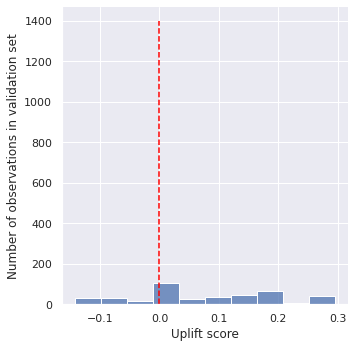

In [96]:
# Check uplift Distribution

sns.displot(data = X_test['uplift_forest_tau'])
plt.vlines([0], 0, 1400, linestyles = "dashed", colors = "red")
plt.xlabel('Uplift score')
plt.ylabel('Number of observations in validation set');

Model Evaluation

In [117]:
def auuc_metric_maker(dataframe, tau_outcome_var, control_category, treatment_category):

  treatment_category_result = X_test[[tau_outcome_var]].reset_index(drop=True)
  treatment_category_result.columns = [treatment_category]

  # If all deltas are negative, assing to control; otherwise assign to the treatment
  # with the highest delta
  best_treatment = np.where(
      (treatment_category_result < 0).all(axis=1),
      control_category,
      treatment_category_result.idxmax(axis=1)
  )
  # Create indicator variables for whether a unit happened to have the
  # recommended treatment or was in the control group
  actual_is_best = np.where(dataframe[treatment_variable] == best_treatment, 1, 0)
  actual_is_control = np.where(dataframe[treatment_variable] == control_category, 1, 0)

  synthetic = (actual_is_best == 1) | (actual_is_control == 1)
  synth = treatment_category_result[synthetic]

  auuc_score = (synth.assign(
      is_treated = 1 - actual_is_control[synthetic],
      visit = dataframe.loc[synthetic, target_variable].values,
      model_result = synth.max(axis=1)
  ).drop(columns=list([treatment_category]))).rename(columns = {"model_result": tau_outcome_var})
 

  return auuc_score

In [118]:
uplift_forest_auuc_score = auuc_metric_maker(X_test, tau_outcome_var = "uplift_forest_tau", control_category = control_category, treatment_category = treatment_category)

In [119]:
uplift_forest_auuc_score.head()

,is_treated,visit,uplift_forest_tau
1,0,1,0.270156
2,0,1,0.129554
3,0,1,0.160699
4,0,1,0.270156
6,0,1,0.130845


In [114]:
target_variable

'event'

In [121]:
metrics.auuc_score(uplift_forest_auuc_score, outcome_col = target_variable, treatment_col='is_treated')

AssertionError: ignored

In [113]:
metrics.qini_score(uplift_forest_auuc_score, outcome_col="target_variable", treatment_col='is_treated')

AssertionError: ignored